In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wmap_camb_example

data to fit: We want the combined (not binned) version of the spectrum. This gives the measured variance of the sky as a function of multipole l. WMAP does not measure the monopole, and the dipole is set by the motion of the Earth/Milky Way relative to the CMB reference frame. So, the spectrum starts with the quadrupole (l = 2). The first column is the multipole index, the second is the measured power spectrum, and the third is the error in that. For simplicity, we will treat the errors as Gaussian and uncorrelated, though that is not quite accurate. The final two columns break down the error into the instrument noise part and the “cosmic variance” part, due to the fact that we only have a finite number of modes in the sky to measure.

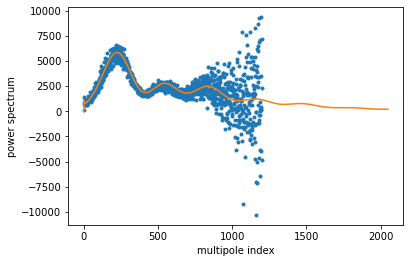

In [3]:
#given code
plt.ion()

#[H_0, w_bh2, w_ch2, tau, A_s, slope]
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])

#[multipole index, measured power spectrum, error, instrument noise part, “cosmic variance” part]
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')

plt.clf();
# plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*', alpha=0.1)
plt.plot(wmap[:,0],wmap[:,1],'.') 

cmb=wmap_camb_example.get_spectrum(pars)

plt.plot(cmb) #what really is the x values here then?
plt.xlabel("multipole index")
plt.ylabel("power spectrum")

plt.show()

### 2) 
Using Gaussian, uncorrelated errors, what do you get for χ2 for the model in my example script, where the Hubble constant H_0 = 65 km/s, the physical baryon density $ω_bh^2=0.02$, the cold dark matter density $ω_ch^2 = 0.1$ the optical depth $τ = 0.05$, the primordial amplitude of fluctuations is $A_s = 2 × 10^{−9}$, and the slope of the primordial power law is 0.96 (where 1 would be scale-invariant). The baryon/dark matter densities are defined relative to the critical density required to close the universe, scaled by h^2 where $h ≡ H_0/100 ∼ 0.7$.   
Note that the universe is assumed to be spatially flat (for reasons too long to justify here), so the dark matter density relative to critical for these parameters would be $1 − (ω_bh^2 + ω_ch^2)/h^2 =71.6%$ for the model assumed here. (You may want to play around plotting different models as you change parameters to get a sense for how the CMB depends on them.)   
If everything has gone well, you should get something around 1588 (please give a few extra digits) for χ2 for this model.

In [56]:
def chisq(data,pars):
    #we need a function that calculates chi^2 for us for the MCMC
    #routine to call
    x=data[0]
    y=data[1]
    noise=data[2]
    
    #set chi to inf if tau is negative to not get these terms
    if pars[3] < 0:
        chisq = np.inf
    else:
        model=cmbfun(x,pars)

        chisq=np.sum( (y-model)**2/noise**2)
    
    return chisq

def cmbfun(x,pars):
    #call the cmb function with the current parameters
    y = wmap_camb_example.get_spectrum(pars, len(x))[:-2]
    return y

In [4]:
#chi: sum( (data - fitted)^2/data ) or over sigma^2

#assuming Gaussian, uncorrelated errors --> N is diagonal and sigma_i is simple the error on each value

# print(len(cmb))
# print(len(wmap[:,1]))

chiSq = 0

#how to actually match up values?
#x is just (1, 2, 3, ...) so this is sorta fine?
for i in range(len(wmap)):
    chiSq +=(wmap[i,1]-cmb[i])**2 / wmap[i,2]**2

print("Chi squared is: {}".format(chiSq)) #hmm not that close

Chi squared is: 1676.467714877247


### 3) 
Keeping the optical depth fixed at 0.05, write a Newton’s method/LevenbergMarquardt minimizer and use it to find the best-fit values for the other parameters, and their errors. What are they?   
If you were to keep the same set of parameter but now float τ, what would you expect the new errors to be? Note that CAMB does not provide derivatives with respect to parameters, so you’ll have to come up with something for that. *Please also provide a plot showing why we should believe your derivative estimates.*

In [5]:
#numerical derivative
def derive(x, params, i, Min, Max, steps):
#     params

    fitP = params[i]

    # var = np.linspace(0 , H_0para + 10)
    var = np.linspace(fitP - Min , fitP + Max, steps)
#     print(var)

    smaller = np.where(var < fitP)[0][-1]
    bigger = np.where(var > fitP)[0][0]
#     print(smaller, bigger, (var[smaller], var[bigger]))
        
    paramArr = [ np.where(params==fitP, v, params) for v in var]

    #quite slow - this is not going to be efficent
    y = np.array([wmap_camb_example.get_spectrum(p, 1820) for p in paramArr])
#     print(y[4])
    
    slope = [(y[bigger,int(j)] - y[smaller,int(j)]) / (var[bigger] - var[smaller]) for j in x]
    
#     print( (y[bigger,50] - y[smaller,50]))
#     print(slope)

    return [slope, y, var]

#numerical derivative
def derive_short(x, params, i, stepSize):

    fitP = params[i]

    # var = np.linspace(0 , H_0para + 10)
    x1 = fitP + stepSize
    x2 = fitP - stepSize
       
    paramArr1 = np.where(params==fitP, x1, params)
    paramArr2 = np.where(params==fitP, x2, params)

    #quite slow - this is not going to be efficent
    y1 = wmap_camb_example.get_spectrum(paramArr1, 1820)
    y2 = wmap_camb_example.get_spectrum(paramArr2, 1820)

#     print(y[4])
    
    slope = [(y1[int(j)] - y2[int(j)]) / (x1 - x2) for j in x]

    return [slope]

In [281]:
# pars_guess=np.asarray([60, 0.02, 0.1, 0.05, 2e-9, 0.96])
# pars_guess=np.asarray([7.46279762e+01, 6.25474176e-03, 1.66248810e-01, 0.05, 1.31297024e-09, 8.13705641e-01])
pars_guess=np.asarray([7.46279762e+01, 1.15e-02, 1.66248810e-01, 0.05, 1.31297024e-09, 8.13705641e-01])

x=wmap[:,0]

# results = derive(x, pars_guess, 0, 10, 10, 8)
results = derive(x, pars_guess, 3, 0.04, 0.04, 8)

slope = results[0]
y = results[1]
var = results[2]

In [282]:
results_short = derive_short(x, pars_guess, 3, 0.04/8)[0]

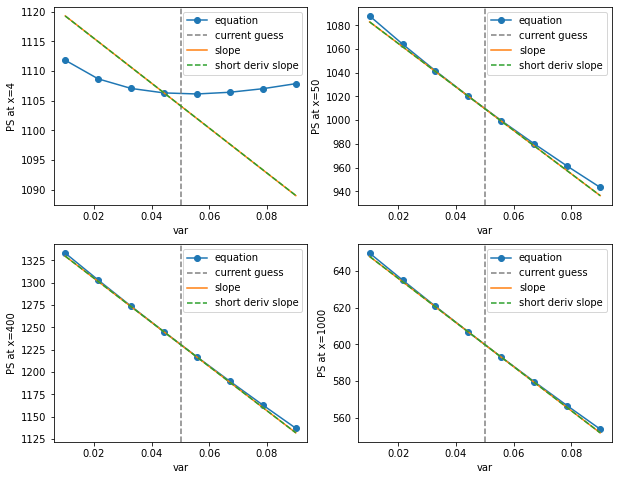

In [283]:
fig, ax = plt.subplots(2, 2, figsize=(10,8))

axs = ax.flatten()
current = pars_guess[3]

for i, x in enumerate([4, 50, 400, 1000]):

    #mx + b
    b = y[3,x] - slope[x]*var[3]
    b_short = y[3,x] - results_short[x]*var[3]


    #dy/dh_0 = y - y_1 / ( h0 - h0_1)

    #dep on x value
    axs[i].plot(var, y[:,x], label='equation', marker="o")
    axs[i].set_xlabel("var")
    axs[i].set_ylabel("PS at x={}".format(x))
    axs[i].axvline(current, color='grey', ls="--", label="current guess")
    axs[i].plot(var, slope[x]*var + b, label='slope')
    axs[i].plot(var, results_short[x]*var + b_short, label='short deriv slope', ls="--")

    axs[i].legend()

plt.show()

In [6]:
#function and derivatives
def f_cmb(x,params):
    H0=params[0]
    ombh2=params[1]
    omch2=params[2]
#     tau=pars[3]
    As=params[3]
    ns=params[4]
    
    pars = np.insert(params, 2, 0.05)
    
#     y = wmap_camb_example.get_spectrum(pars, lmax=len(x)) #give a length of 1201?
    y = wmap_camb_example.get_spectrum(pars, lmax=len(x))[:-2]
    
    derivs=np.zeros([len(x),len(params)])
    
    derivs[:,0]=derive_short(x, pars, 0, 4)[0]
    derivs[:,1]=derive_short(x, pars, 1, 0.001/2.0)[0]
    derivs[:,2]=derive_short(x, pars, 2, 0.05/2.0)[0]
    derivs[:,3]=derive_short(x, pars, 4, 1e-9/2.0)[0]
    derivs[:,4]=derive_short(x, pars, 5, 0.5/2.0)[0]
    
    return y,derivs

The iterative update is dependent on the value of an algorithmic parameter, λ— a non-negative damping factor which smooths out the graph. The update is Gauss-Newton if λ is small (i.e. close to the optimal value) and a gradient descent if λ is large (Gavin, 2007). The Gauss-Newton is more accurate and faster than the gradient descent when close to the minimum error. 
Therefore, so the algorithm will migrate towards the GN algorithm as soon as possible.

In [22]:
# newton's method
# add in Levenberg-Marquardt?

x=wmap[:,0]

sig=wmap[:,2]
y=wmap[:,1]
N=np.eye(len(x))*sig**2
Ninv=np.eye(len(x))/sig**2

# print(N)

tau = 0.05 #set
#[H_0, w_bh2, w_ch2, _, A_s, slope]
pars_guess=np.asarray([65, 0.02, 0.1, 2e-9, 0.96])

pars_cur=pars_guess.copy()

pars_savedArr = []

for iter in range(15):
    y_pred,derivs=f_cmb(x,pars_cur)
    resid=y-y_pred #data minus current model
#     print(resid)
    
    rhs=derivs.T@(Ninv@resid)
    lhs=derivs.T@Ninv@derivs
#     print(rhs, lhs)
    
    step=np.linalg.inv(lhs)@rhs
    
    pars_cur=pars_cur+step
    pars_savedArr.append(pars_cur)
    
    print('iteration ',iter,' has step ',step)
    
    chi_pars = np.insert(pars_cur, 2, 0.05)
    
    chiS = chisq([x, y, sig], chi_pars)
    print("chisq: ", chiS)
    
    
par_errs2=np.sqrt(np.diag(np.linalg.inv(lhs)))
print('final parameters are ',pars_cur,' with errors ',par_errs2)

# broke on param [7.46279762e+01 6.25474176e-03 1.66248810e-01 1.31297024e-09 8.13705641e-01]
#[1] = -3.77757475e-03

iteration  0  has step  [ 3.69894766e+01 -5.20614231e-03 -2.35795562e-02 -7.84994057e-10
 -7.54600838e-03]
chisq:  4555.744458116236
iteration  1  has step  [-5.02003065e+00  1.00148661e-02  8.25911613e-03  4.48931812e-10
  6.68210316e-02]
chisq:  1950.0158159790083
iteration  2  has step  [-1.73885319e+01 -4.98182007e-03  2.45593099e-02  1.88109831e-10
 -5.46810550e-02]
chisq:  5180.560149990988
iteration  3  has step  [ 1.73620086e+01 -1.00670037e-03 -3.01484633e-04 -1.99387120e-10
  1.33707784e-02]
chisq:  1525.939102893733
iteration  4  has step  [-6.85765649e+00  3.06547421e-03  1.53696032e-02  2.14767776e-10
  1.45842035e-02]
chisq:  2878.5413602505873
iteration  5  has step  [-4.66717788e-01 -1.43147534e-03  1.31524839e-02  2.67927623e-11
 -9.26255341e-03]
chisq:  2676.67188650801
iteration  6  has step  [2.17199894e+00 3.61391848e-04 1.14049860e-02 3.72225810e-11
 7.08740547e-03]
chisq:  2383.766373506086
iteration  7  has step  [-1.17453163e+00  3.55115009e-04  1.35476619e-02 

In [ ]:
# newton's method with in Levenberg-Marquardt

x=wmap[:,0]

sig=wmap[:,2]
y=wmap[:,1]
N=np.eye(len(x))*sig**2
Ninv=np.eye(len(x))/sig**2

tau = 0.05 #set
#[H_0, w_bh2, w_ch2, _, A_s, slope]
pars_guess=np.asarray([65, 0.02, 0.1, 2e-9, 0.96])

pars_cur=pars_guess.copy()

pars_savedArr = []
Lambda = 0
prev_chi = np.inf

for iter in range(25):
    y_pred,derivs=f_cmb(x,pars_cur)
    resid=y-y_pred #data minus current model
#     print(resid)

    #rescale diagonal 
    for i in range(len(derivs[0])):
        derivs[i][i] = (1+Lambda)*derivs[i][i]
    
    rhs=derivs.T@(Ninv@resid)
    lhs=derivs.T@Ninv@derivs
#     print(rhs, lhs)
    
    step=np.linalg.inv(lhs)@rhs
    
    chi_pars = np.insert(pars_cur+step, 2, 0.05)
    chi = chisq([x, y, sig], chi_pars)
    
    #chiSq improves, take step
    if chi < prev_chi:
        pars_cur = pars_cur+step
        pars_savedArr.append(pars_cur) #save values for corvarience matrix
        prev_chi = chi #save new chqsquared for next step
        
        Lambda = Lambda / np.sqrt(2) #make lambda setp smaller
        print('iteration ',iter,' has step ',step)

    
    #chiSq doesn't improves, take step according to lambda    
    else:
        if Lambda == 0:
            Lambda = 2
        else:
            Lambda = 2*Lambda
#             pars_cur = pars_cur+step
        print('iteration ',iter,' increase lambda to ',Lambda)
    
    print("chisq: ", chi)
    
    
par_errs2=np.sqrt(np.diag(np.linalg.inv(lhs)))
print('final parameters are ',pars_cur,' with errors ',par_errs2)

# broke on param [7.46279762e+01 6.25474176e-03 1.66248810e-01 1.31297024e-09 8.13705641e-01]
#[1] = -3.77757475e-03

iteration  0  has step  [ 3.69894766e+01 -5.20614231e-03 -2.35795562e-02 -7.84994057e-10
 -7.54600838e-03]
chisq:  4555.744458116236
iteration  1  has step  [-5.02003065e+00  1.00148661e-02  8.25911613e-03  4.48931812e-10
  6.68210316e-02]
chisq:  1950.0158159790083
iteration  2  increase lambda to  2
chisq:  5180.560149990988


In [53]:
#get guess at covarience matrix from this, what about diagonal, do we still use sigma^2 or these values here??

#is is what i should be using? I'm skipping the first set of params cause those where my initial guess
delt = np.insert(pars_savedArr, 2, 0.05, axis=1)
# print(pars_savedArr)
# print(delt)

# delt = np.array()

# delt=chain2.copy()
for i in range(delt.shape[1]):
#     print(delt[:,i], delt[:,i].mean())
    delt[:,i]=delt[:,i]-delt[:,i].mean()
    
#by using a covariance matrix to draw trial steps from,
#we get uncorrelated samples much, much faster than
#just taking uncorrelated trial steps


mycov=delt.T@delt/delt.shape[0]
print(mycov)
# print(N)

# chain3,chivec3=run_chain_corr(pars_guess,chifun_sinh,[x,y,sig],mycov,20000)

[[ 4.68953513e+00 -3.25690421e-03  1.40868019e-32 -2.37710291e-02
  -3.20948708e-10 -2.35353948e-02]
 [-3.25690421e-03  7.44553011e-06 -3.43916061e-36  2.70046769e-05
   4.21552971e-13  5.37874794e-05]
 [ 1.40868019e-32 -3.43916061e-36  4.81482486e-35 -5.50265698e-35
  -4.09979894e-43  9.90478257e-34]
 [-2.37710291e-02  2.70046769e-05 -5.50265698e-35  2.48390347e-03
   1.31135845e-11  6.38168450e-04]
 [-3.20948708e-10  4.21552971e-13 -4.09979894e-43  1.31135845e-11
   8.21307816e-20  5.12076446e-12]
 [-2.35353948e-02  5.37874794e-05  9.90478257e-34  6.38168450e-04
   5.12076446e-12  4.78439786e-04]]


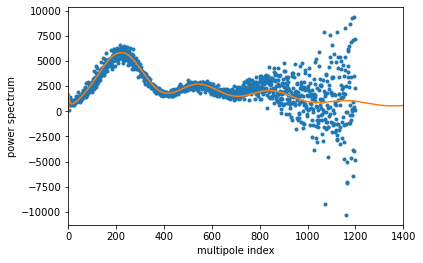

In [54]:
#[H_0, w_bh2, w_ch2, tau, A_s, slope]
pars_fitted=np.insert(pars_cur, 2, 0.05)

#[multipole index, measured power spectrum, error, instrument noise part, “cosmic variance” part]

# plt.errorbar(wmap[:,0],wmap[:,1],wmap[:,2],fmt='*', alpha=0.1)
plt.plot(wmap[:,0],wmap[:,1],'.') 

cmb=wmap_camb_example.get_spectrum(pars_fitted)

plt.plot(cmb) #what really is the x values here then?
plt.xlabel("multipole index")
plt.ylabel("power spectrum")
plt.xlim(0, 1400)

plt.show()

In [62]:
# If you were to keep the same set of parameter but now float τ, what would you expect the new errors to be?

#function and derivatives
def f_cmb_tau(x,tau):
#     tau=pars[3]

    pars = np.insert(pars_cur, 3, tau)
    print(pars)
    
#     y = wmap_camb_example.get_spectrum(pars, lmax=len(x)) #give a length of 1201?
    y = wmap_camb_example.get_spectrum(pars, lmax=len(x))[:-2]
    
    derivs=np.zeros([len(x),1])
    
    derivs[:,0]=derive_short(x, pars, 3, 0.005)[0]
    
    return y,derivs

In [64]:
x=wmap[:,0]

sig=wmap[:,2]
y=wmap[:,1]
N=np.eye(len(x))*sig**2
Ninv=np.eye(len(x))/sig**2

tau_cur = 0.05 #set

#using the L-M method, just add prior into chi squared
tau_savedArr = []
Lambda = 0
prev_chi = np.inf

for iter in range(8):
    
    if tau_cur < 0:
        print("problem, negative tau")
#         tau_cur = np.abs(tau_cur) #how can i actually fix this?

    y_pred,derivs=f_cmb_tau(x,tau_cur)
    resid=y-y_pred #data minus current model
    
    print(derivs)

    #maybe this isn't the right matrix?
    for i in range(len(derivs[0])):
#         print(derivs[i][i])
        derivs[i][i] = (1+Lambda)*derivs[i][i]
    
    rhs=derivs.T@(Ninv@resid)
    lhs=derivs.T@Ninv@derivs
#     print(rhs, lhs)
    
    step=np.linalg.inv(lhs)@rhs
    
#     chi_pars = np.insert(pars_cur+step, 2, 0.05)
    chi_pars = np.insert(pars_cur, 3, tau_cur+step)
    chi = chisq([x, y, sig], chi_pars)
    
        #chiSq improves, take step
    if chi < prev_chi:
        tau_cur=tau_cur+step
        tau_savedArr.append(tau_cur) #save values for corvarience matrix
        prev_chi = chi #save new chqsquared for next step
        
        Lambda = Lambda / np.sqrt(2) #make lambda setp smaller
        print('iteration ',iter,' has step ',step)

    #chiSq doesn't improves, take step according to lambda    
    else:
        if Lambda == 0:
            Lambda = 2
        else:
            Lambda = 2*Lambda
#             pars_cur = pars_cur+step
        print('iteration ',iter,' increase lambda to ',Lambda, ' tried step ',step)
    
    print("chisq: ", chi)    
    
par_errs=np.sqrt(np.diag(np.linalg.inv(lhs)))
print('final parameters are ', tau_cur,' with errors ',par_errs)

[9.89369814e+01 2.10236451e-02 1.96373573e-01 5.00000000e-02
 2.05678053e-09 1.01124073e+00]
[[  249.80650696]
 [  145.28456995]
 [  -11.48901928]
 ...
 [-1539.99993796]
 [-1542.82016875]
 [-1545.60484936]]
iteration  0  increase lambda to  2  tried step  [-0.1332416]
chisq:  inf
[9.89369814e+01 2.10236451e-02 1.96373573e-01 5.00000000e-02
 2.05678053e-09 1.01124073e+00]
[[  249.80650696]
 [  145.28456995]
 [  -11.48901928]
 ...
 [-1539.99993796]
 [-1542.82016875]
 [-1545.60484936]]
iteration  1  increase lambda to  4  tried step  [-0.13323998]
chisq:  inf
[9.89369814e+01 2.10236451e-02 1.96373573e-01 5.00000000e-02
 2.05678053e-09 1.01124073e+00]
[[  249.80650696]
 [  145.28456995]
 [  -11.48901928]
 ...
 [-1539.99993796]
 [-1542.82016875]
 [-1545.60484936]]
iteration  2  increase lambda to  8  tried step  [-0.13323761]
chisq:  inf
[9.89369814e+01 2.10236451e-02 1.96373573e-01 5.00000000e-02
 2.05678053e-09 1.01124073e+00]
[[  249.80650696]
 [  145.28456995]
 [  -11.48901928]
 ...
 [-

KeyboardInterrupt: 

### 4) 
Now write a Markov-chain Monte Carlo where you fit the basic 6 parameters, including τ. However, note that we know the optical depth can’t be negative, so you should reject any steps that try to sample a negative τ.   

As a reminder, you can draw samples of correlated data from a covariance matrix with   
r = np.linalg.cholesky(mat);   
d = np.dot(r, np.random.randn(r.shape[0])).    
You will want to use the covariance matrix from part 2) (3?) when drawing samples for the MCMC.   

What are your parameter limits now? Please also present an argument as to why you think your chains are converged.   

In [248]:
print(pars_cur)

[ 7.93143952e+01 -2.86943803e-03  1.53661549e-01  4.05062814e-10
  6.89924867e-01]


### 5) 
The Planck satellite has independently measured the CMB sky, and finds
that the optical depth is 0.0544 ± 0.0073. Run a chain where you add this in as a prior on the value of τ. What are your new parameter values/constraints?    
You can also take your chain from part 4) and importance sample it (weighting by the prior) with the Planck τ prior. How to those results compare to the full chain results?   
(p316 in tb)